<a href="https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/TDG041821V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
pip install --upgrade kmodes

In [19]:
from google.colab import drive
import pandas as pd
import numpy as np

from kmodes.kprototypes import KPrototypes

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

from plotnine import *
import plotnine

In [2]:
plot_kwds = {'alpha' : 0.5, 's' : 1, 'linewidths':0}

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Dataset de inventarios sin dimensiones de los productos
data4 = pd.read_csv("/content/gdrive/MyDrive/TDGdata/dfNoDims.csv")

In [5]:
data4

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR,CONTRPERC
0,17,IG56,HTS119,1/1,B,PC,CAT17,-289.8802,-2.63,0.01
1,17,IG56,HTS119,1/1,B,PC,CAT17,289.5527,25.00,0.00
2,17,IG56,HTS119,1/1,C,PC,CAT17,1111.3121,50.00,0.00
3,17,IG56,HTS119,1/1,B,PC,CAT17,-266.8633,-9.09,0.00
4,15,IG56,HTS119,1/1,C,PC,CAT17,-517.0436,-11.11,0.00
...,...,...,...,...,...,...,...,...,...,...
16239,23,IG5,HTS67,1/0,C,BX,CAT2,316.3834,1.00,0.00
16240,21,IG5,HTS67,1/0,C,BX,CAT2,626.9100,1.00,0.00
16241,22,IG5,HTS67,1/0,C,BX,CAT2,4959.6974,136.36,0.00
16242,24,IG5,HTS67,1/0,C,BX,CAT2,-1322.5860,-100.00,0.00


In [6]:
data4['CAT'] = data4['CAT'] + "-" + data4['ABC']

In [7]:
data4['AISLE']=data4['AISLE'].astype(str)

In [8]:
data4 =  data4.drop(['IG','HTS','PLANNING','ABC','UOM','COSTX','CONTRPERC'], axis=1)

In [9]:
data4.sample(5)

,AISLE,CAT,QTYVAR
10010,15,CAT17-C,33.33
8167,9,CAT7-C,-50.00
2407,7,CAT7-A,-100.00
5641,4,CAT12-A,-100.00
12474,29,CAT14-A,-100.00


In [10]:
numdf = data4[list(data4.select_dtypes('float64').columns)]

In [11]:
catdf = data4[list(data4.select_dtypes('object').columns)]

In [12]:
from sklearn.metrics import silhouette_score
import time

dataNum=numdf.to_numpy()
dataCat=catdf.to_numpy()
N = data4.shape[0]

# gamma = 0.5 (constante)
catWeight=0.5

start_time = time.time()

# Inicializamos la matriz de distancias con ceros
scores = [ [ 0 for i in range(N) ] for j in range(N) ]

# Calculamos la mitad de la matriz distancias
for i in range(N):
  for j in range(i+1,N):
    scores[i][j]=np.sum((dataNum[i] - dataNum[j]) ** 2) + catWeight * np.sum(dataCat[i]!=dataCat[j])
print("Matriz de distancias --- %s seconds ---" % (time.time() - start_time))

# Completamos la matriz
for i in range(0,N):
  for j in range(0,i):
    scores[i][j]=scores[j][i]
print("Espejo --- %s seconds ---" % (time.time() - start_time))

Matriz de distancias --- 2478.4870235919952 seconds ---
Espejo --- 2569.3505668640137 seconds ---


In [14]:
scores[1][0:10]

[763.4168999999999,
 0,
 625.5,
 1162.1281000000001,
 1304.9321,
 3150625.5,
 1914.5625,
 15625.5,
 0.5,
 137.1889]

In [15]:
catColumnsPos = [data4.columns.get_loc(col) for col in list(data4.select_dtypes('object').columns)]

In [20]:
# gamma = 0.5 (constante)

cost = []
silueta = []
start_time = time.time()

for k in (list(range(1,6)) + [10]):
  try:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = 0.5, random_state = 0)
    kprototype.fit_predict(data4, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('k: {}'.format(k))
    print("--- %s seconds ---" % (time.time() - start_time))
    if k != 1:
      silhouette_coeff = silhouette_score(scores, kprototype.labels_, metric='precomputed')
      silueta.append(silhouette_coeff)
      print("Coeficiente silueta --- %s seconds ---" % (time.time() - start_time))
      print(silhouette_coeff)

  except:
    break

k: 1
--- 23.923835277557373 seconds ---
k: 2
--- 92.38871312141418 seconds ---
Coeficiente silueta --- 143.49812698364258 seconds ---
0.9993227538056179
k: 3
--- 284.7543058395386 seconds ---
Coeficiente silueta --- 336.0188319683075 seconds ---
0.9972528204261965
k: 4
--- 596.5842230319977 seconds ---
Coeficiente silueta --- 646.9494624137878 seconds ---
0.9956751610203323
k: 5
--- 865.5202059745789 seconds ---
Coeficiente silueta --- 915.4215693473816 seconds ---
0.9895932773778049


In [22]:
df_cost = pd.DataFrame({'Cluster':range(1,6), 'Cost':cost})
df_silueta = pd.DataFrame({'Cluster':range(2,6), 'Coeficiente':silueta})

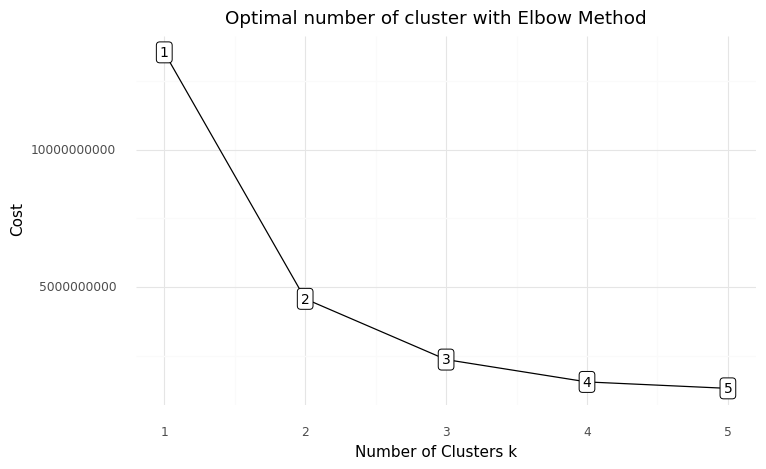

<ggplot: (8743430885061)>

In [23]:
# Codo
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_cost)+
geom_line(aes(x = 'Cluster',
y = 'Cost'))+
geom_point(aes(x = 'Cluster',
y = 'Cost'))+
geom_label(aes(x = 'Cluster',
y = 'Cost',
label = 'Cluster'),
size = 10,
nudge_y = 1000) +
labs(title = 'Optimal number of cluster with Elbow Method')+
xlab('Number of Clusters k')+
ylab('Cost')+
theme_minimal()
)

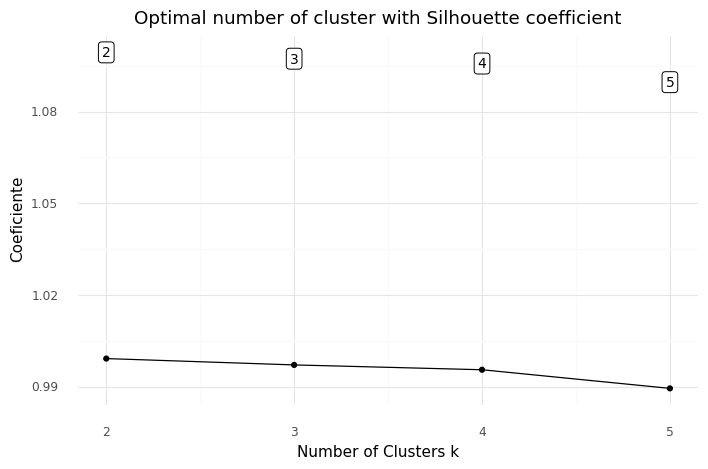

<ggplot: (8743431496897)>

In [24]:
# Coeficiente silueta
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_silueta)+
geom_line(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_point(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_label(aes(x = 'Cluster',
y = 'Coeficiente',
label = 'Cluster'),
size = 10,
nudge_y = 0.1) +
labs(title = 'Optimal number of cluster with Silhouette coefficient')+
xlab('Number of Clusters k')+
ylab('Coeficiente')+
theme_minimal()
)